In [1]:
# imports

from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

# set random seeds for reproducibility
random.seed(0)
np.random.seed(0)

# Fake News Detector Project

References:
* [Fake News Detector Model AI Assignment](http://modelai.gettysburg.edu/2019/fakenews/) and [source for this notebook](http://modelai.gettysburg.edu/2019/fakenews/proj3/index.html)
* [Sci-Kit Learn (sklearn) Naive Bayes page](https://scikit-learn.org/stable/modules/naive_bayes.html)

## Project 3: Fake News! <img style="float: right;" src="fake_news.png" width="400px">

For this project, you will build and analyze several algorithms for determining whether a headline is real or fake news.

### Data: Fake and real news headlines

We have compiled 1298 "fake news" headlines (which mostly include headlines of articles classified as biased etc.) and 1968 "real" news headlines, where the
"fake news" headlines are from <https://www.kaggle.com/mrisdal/fake-news/data>
and "real news" headlines are from <https://www.kaggle.com/therohk/million-headlines>.
We further cleaned the data by removing words from fake news titles that are
not a part of the headline, removing special characters from the headlines, and
restricting real news headlines to those after October 2016 containing the word
"trump". For your interest, the cleaning script is available at [clean_script.py](clean_script.py),
but you do not need to run it. The cleaned-up data is available below:

* Real news headlines: [clean_real.txt](clean_real.txt)
* Fake news headlines: [clean_fake.txt](clean_fake.txt)

Each headline appears as a single line in the data file. Words in the headline are
separated by spaces, so just use `str.split()` in Python to split the headlines
into words.

### Part 1 (2 pts)

Describe the datasets. You will be predicting whether a headline is real or
fake news from words that appear in the headline. Is that feasible? Give 3
examples of specific keywords that may be useful, together with statistics
on how often they appear in real and fake headlines.

For the rest of the project, you should split your dataset into ~70% training,
~15% validation, and ~15% test.


In [2]:

real_lines = [line.strip() for line in open('clean_real.txt', 'r').readlines()]
print('# real headlines', len(real_lines))
fake_lines = [line.strip() for line in open('clean_fake.txt', 'r').readlines()]
print('# fake headlines', len(fake_lines))

real_words = ' '.join(real_lines).split(' ')
fake_words = ' '.join(fake_lines).split(' ')
all_words = list(set(real_words).union(fake_words))

# create shuffled 70/15/25 train/validation/test datasets
real_label, fake_label = (1,0)
x = real_lines + fake_lines
y = len(real_lines) * [real_label] + len(fake_lines) * [fake_label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True, random_state = 0)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, shuffle = True, random_state = 0)

# real headlines 1968
# fake headlines 1298


### Part 2 (20 pts)

Implement the Naive Bayes algorithm for predicting whether a headline is
real or fake. Tune the parameters of the prior
(called $m$ and $\hat{p}$ on [slide 23](http://modelai.gettysburg.edu/2019/fakenews/proj3/slide23.pdf) of the Generative Classifiers lecture)
using the validation set. Report
how you did it, and the result. Report the performance on the
training and the test sets that you obtain. Note that computing products
of many small numbers leads to underflow. Use the fact that
$$a_ 1 a_ 2 ... a_ n = \exp(\log a_1 + \log a_2 + ... \log a_n)$$
In your report, explain how you used that fact.

Top 20 Real Headline Frequent Words: 


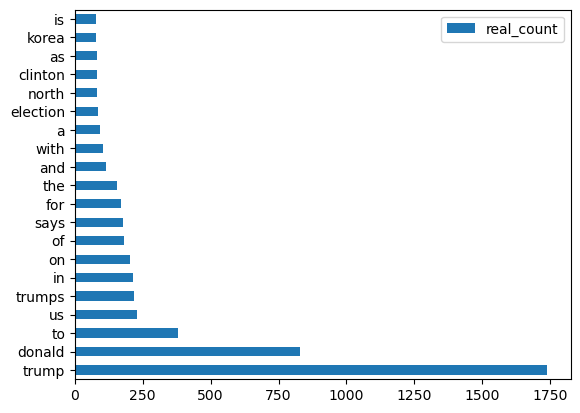

Top 20 Fake Headline Frequent Words: 


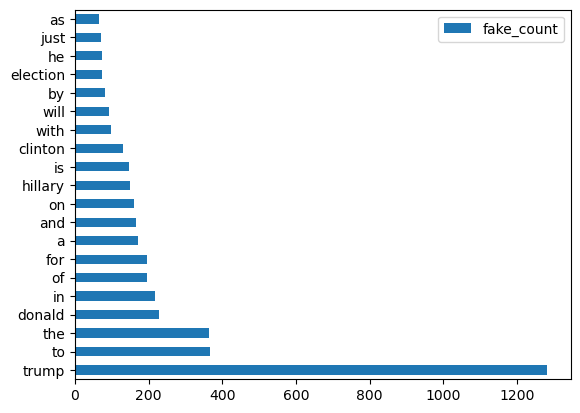

Using a Naive Bayes Classifier based on 70% training data:
Training accuracy  = 0.947069116360455 for m=0.5, p_hat=1
Validation accuracy  = 0.8734693877551021 for m=0.5, p_hat=1
Testing accuracy  = 0.863265306122449 for m=0.5, p_hat=1


In [3]:
def get_nb_df(x,y):
    real_lines = [x for i,x in enumerate(x) if y[i] == real_label] 
    fake_lines = [x for i,x in enumerate(x) if y[i] == fake_label] 
    real_fake_data = {word: [sum([word in line.split(' ') for line in real_lines]), 
                                sum([word in line.split(' ') for line in fake_lines])] 
                        for word in all_words}

    df = pd.DataFrame(data = real_fake_data).T
    df.columns = ['real_count', 'fake_count']
    return (df, len(real_lines), len(fake_lines))

df, num_real, num_fake = get_nb_df(x,y)
num_top_word = 20
print(f'Top {num_top_word} Real Headline Frequent Words: ')
df.sort_values('real_count', ascending = False, inplace= True)
df[:20].plot(kind = 'barh', y = 'real_count')
plt.show()

print(f'Top {num_top_word} Fake Headline Frequent Words: ')
df.sort_values('fake_count', ascending = False, inplace= True)
df[:20].plot(kind = 'barh', y = 'fake_count')
plt.show()


nb_hash = 0
nb_df = pd.DataFrame()
nb_log_likelihood = 1

def naive_bayes(headline, df, num_real_lines, num_fake_lines, m, p_hat):
    global nb_hash, nb_df, nb_log_likelihood
    new_hash = hash(num_real_lines) + hash(num_fake_lines) + hash(m) + hash(p_hat)
    if nb_hash != new_hash or not df.equals(nb_df): # if there's been a change
        # ... recompute empty headline log likelihood
        nb_hash = new_hash
        nb_df = df
        nb_log_likelihood = math.log(num_real_lines / num_fake_lines)
        
        for word in df.index:
            real_prob = 1 - (df.loc[word]['real_count'] + m * p_hat) / (num_real_lines + m)
            fake_prob = 1 - (df.loc[word]['fake_count'] + m * p_hat) / (num_fake_lines + m)
            nb_log_likelihood += math.log(real_prob / fake_prob)
    words = headline.strip().split(' ')
    # start with the assumption of precomputed empty headline log_likelyhood and adjust for headline words
    log_likelihood = nb_log_likelihood 
    for word in words:
        if word in df.index:
            # subtract default absent word term 
            real_prob = 1 - (df.loc[word]['real_count'] + m * p_hat) / (num_real_lines + m)
            fake_prob = 1 - (df.loc[word]['fake_count'] + m * p_hat) / (num_fake_lines + m)
            log_likelihood -= math.log(real_prob / fake_prob)
            # add present word term
            real_prob = 1 - real_prob
            fake_prob = 1 - fake_prob
            log_likelihood += math.log(real_prob / fake_prob)
        else: # optional
            log_likelihood += math.log((num_fake_lines + m) / (num_real_lines + m))
    return real_label if log_likelihood > 0 else fake_label



def get_accuracy(X, y, df, num_real_lines, num_fake_lines, m, p_hat):
    correct = sum([naive_bayes(x, df, num_real_lines, num_fake_lines, m, p_hat) == correct_label
        for x, correct_label in zip(X, y)] )
    return correct / len(X)


df_train, num_real_lines_train, num_fake_lines_train = get_nb_df(x_train, y_train)

m = 0.5
p_hat = 1

print('Using a Naive Bayes Classifier based on 70% training data:')
print(f'Training accuracy  = {get_accuracy(x_train, y_train, df_train, num_real_lines_train, num_fake_lines_train, m, p_hat)} for m={m}, p_hat={p_hat}')

df_val, num_real_lines_val, num_fake_lines_val = get_nb_df(x_val, y_val)
print(f'Validation accuracy  = {get_accuracy(x_val, y_val, df_train, num_real_lines_train, num_fake_lines_train, m, p_hat)} for m={m}, p_hat={p_hat}')

df_test, num_real_lines_test, num_fake_lines_test = get_nb_df(x_test, y_test)
print(f'Testing accuracy  = {get_accuracy(x_test, y_test, df_train, num_real_lines_train, num_fake_lines_train, m, p_hat)} for m={m}, p_hat={p_hat}')


## Final CS371
#### Naive Bayes Fake News Classifcation


In [25]:
vectorizer = CountVectorizer()
counts_train = vectorizer.fit_transform(x_train)

mNB = MultinomialNB()
mNB = mNB.fit(counts_train, y_train)

counts_test = vectorizer.transform(x_test)

predictions = mNB.predict(counts_test)

predictions = list(predictions)

print(f"length of predictions: {len(predictions)}")
print(predictions)

print(f"length of y_test: {len(y_test)}")
print(y_test)

length = len(y_test)

diff_num = 0
for i in range(0, length):
    if y_test[i] != predictions[i]:
        diff_num += 1

print(f"number of different entries: {diff_num}")
accuracy = 1 - diff_num / length

print(accuracy)

# the accuracy is 0.8306122448979592

length of predictions: 490
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 

In [14]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB

rng = np.random.RandomState(1)
X = rng.randint(5, size=(6, 100))
print(len(X))
y = np.array([1, 2, 3, 4, 5, 6])
clf = MultinomialNB(force_alpha=True)
clf.fit(X, y)
MultinomialNB(force_alpha=True)

print(clf.predict(X[2:3]))

6
[3]


References:
* [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/)
* [Spam classification example from Wikipedia NB Classifier article](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification)
* [Additive Smoothing (shown in slide 23)](https://en.wikipedia.org/wiki/Additive_smoothing)
* [Multinomial Naive Bayes Classifier for Text Analysis (Python)](https://towardsdatascience.com/multinomial-naive-bayes-classifier-for-text-analysis-python-8dd6825ece67)

### Part 3 (15 pts)

#### Part 3(a) (10 pts)

List the 10 words whose presence most strongly predicts that the news is real.

List the 10 words whose *absence* most strongly predicts that the news is real.

List the 10 words whose presence most strongly predicts that the news is fake.

List the 10 words whose *absence* most strongly predicts that the news is fake.

State how you obtained
those in terms of the the conditional probabilities used in the Naive Bayes
algorithm.
Compare the influence of presence vs absence of words on predicting
whether the headline is real or fake news.

#### Part 3(b) (3 pts)

You may find common words like "a", "to", and others in your list in Part 3(a).
These are called stopwords. A list of stopwords is available in sklearn
[here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py).
You can import this as follows:

<pre>
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
</pre>

Now, list the 10 non-stopwords that most strongly predict that the news is real,
and the 10 non-stopwords that most strongly predict that the news is fake.

#### Part 3(c) (2 pts)

Why might it make sense to remove stop words when interpreting the model? Why might it make
sense to keep stop words? 

### Part 4 (15 pts)

Train a Logistic Regression model on the same dataset. For a single headline $h$
the input to the Logistic Regression model will be a $k$-dimensional vector $v$,
where $v[k]=1$ if the $k$-th keyword appears in the headline $h$, and $v[k]=0$
otherwise.  The set of keywords consists of all the words that appear in all
the headlines.  You may use your implementation of Logistic Regression from the
previous projects, or any other implementation of your choice.

Plot the learning curves (performance vs. iteration) of the Logistic Regression
model. Describe how you selected the regularization parameter (and describe the
experiments you used to select it).

### Part 5 (5 pts)

At test time, both Logistic Regression and Naive Bayes can be formulated as computing 

$$\theta_0 + \theta_1 I_1 (x) + \theta_2 I_2 (x) + ... + \theta_k I_k (x) > \text{thr}$$

in order to decide whether to classify the input $x$ as $1$ or $0$. Explain, in each case, what the $\theta$'s and the $I$'s are. 

### Part 6 (13 pts)

#### Part 6(a) (5 pts)

In your report, display a list of top 10 positive $\theta$ and top 10 negative $\theta$ values 
obtained from Logistic Regression, and the words that they correspond with.
How do these lists compare with those in part 3(a)?
Do you notice any similarities or differences?

#### Part 6(b) (3 pts)

Do the same as the previous part, but ignore all stop words.
How do these lists compare with those in part 3(b)?

#### Part 6(c) (5 pts)

In this project, we used the magnitude of the logistic regression parameters
to indicate importance of a feature.  Why might this be a bad idea in
general? (Hint: what if the features are not normalized?) Why is it
reasonable to use the magnitude in this problem?

### Part 7 (20 pts)

In this part, you will build a decision tree to classify real vs fake news
headlines. Instead of coding the decision trees yourself, you will do what
we normally do in practice -- use an existing implementation.
You should use the DecisionTreeClassifier included in sklearn. Note that
figuring out how to use this implementation is a part of the assignment.

Here's a link to the documentation of sklearn.tree.DecisionTreeClassifier

<http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html>

#### Part 7(a) (10 pts)

Train the decision tree classifier. Show the relationship between the max_depth of the tree,
and the training / <strike>test</strike> validation accuracy. You should try around 10 different values of max_depth.
Choose the best-performing decision tree classifier for the following parts. Explain how
you made the choice. Also, explain other parameters of DecisionTreeClassifier for which
you are using non-default values, and how you determined those parameters.

#### Part 7(b) (5 pts)

Extract and visualize the first two layers of the tree. Your visualization may look
something like what is shown below, but it does not have to be an image: it is perfectly fine
to display text. Include your visualization in your report.

<img src="tree.png" width="400px">

How do the most important features in Naive Bayes (Part 3a) and Logistic Regression (Part 6a) 
compare with the features chosen by the decision tree in your visualization?

#### Part 7(c) (5 pts)

Summarize the performance of your three classifiers on the training,
validation, and test sets. Which classifier performed best? The worst?
Which one overfit the most?

### Part 8 (10 pts)

#### Part 8(a) (5 pts)

For the first split of your Decision Tree from Part 7, compute the mutual
information of the split on the
training data.  That is, compute $I(Y,x_i)$ where $Y$ is the random variable
signifying whether a headline is real or fake, and $x_i$ is the keyword
chosen for the top most split.

You can do this either by hand or by writing a function. In either case,
include the code or all the steps involved in your computation in your
writeup.

#### Part 8(b) (5 pts)

Choose another variable $x_j \ne x_i$, and compute $I(Y,x_j)$.
Again, include all code or steps used in your computation in your
writeup.  How does this value compare to what you obtained in 8(a)?

## What to submit

The project should be implemented using Python 2 or 3 and should be runnable on the CS Teaching Labs computers.  Your report should be in PDF format. You should use LaTeX to generate the report, and submit the .tex file as well. A sample template is on the course website. You will submit at least the following files: `fake.py`, `fake.tex`, and `fake.pdf`. You may submit more files as well. You may submit `ipynb` files in place of `py` files.

Reproducibility counts! We should be able to obtain all the graphs and figures in your report by running your code. The only exception is that you may pre-download the images (what and how you did that, including the code you used to download the images, should be included in your submission.) Submissions that are not reproducible will not receive full marks. If your graphs/reported numbers cannot be reproduced by running the code, you may be docked up to 20%. (Of course, if the code is simply incomplete, you may lose even more.) Suggestion: if you are using randomness anywhere, use `numpy.random.seed()`.

You must use LaTeX to generate the report. LaTeX is the tool used to generate virtually all technical reports and research papers in machine learning, and students report that after they get used to writing reports in LaTeX, they start using LaTeX for all their course reports. In addition, using LaTeX facilitates the production of reproducible results.